#**ASSIGNMENT**

**OBJECTIVE :**

Classifying videos (based on description) in following 6 categories –

*   Travel Blogs
*   Science and Technology
*   Food
*   Manufacturing
*   History
*   Art and Music

**NOTE**

Here we have used 3 different models for the classifiaction :- 


*   Logistic Regression (Linear classifier)
*   Shallow Neural Nets 
*   LSTM




In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Importing the required libraries**

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sn
import math
from scipy.sparse import find
from gensim.models import KeyedVectors
from sklearn.externals import joblib
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from scipy.sparse import hstack
from sklearn.metrics import f1_score

In [0]:
df1 = pd.read_csv('combined.csv')

In [6]:
df1.head(5)

,Unnamed: 0,video_id,title,description,category
0,0,13E5azGDK1k,FINE ART Music and Painting PEACEFUL SELECTION...,"CALM MELODIES AND BEAUTIFUL PICTURES Debussy, ...",art and music
1,1,8XdHP_fQoB0,Beautiful Paintings + Beautiful Classical Music,Beautiful selected paintings combine with some...,art and music
2,2,tsKlRF2Gw1s,The Great Masterpieces of Art & Music,Skip the art museum and come experience “Great...,art and music
3,3,1b8xiXKd9Kk,"Art: music & painting - Van Gogh on Caggiano, ...",Buy “Art: Music & Painting - Van Gogh on on Ca...,art and music
4,4,unuiaZleQ5c,Healing Flute Meditation Music For Positive En...,This is the official YouTube channel of The Ar...,art and music


In [0]:
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10496 entries, 0 to 8764
Data columns (total 4 columns):
video_id       10496 non-null object
title          10493 non-null object
description    10335 non-null object
category       10496 non-null object
dtypes: object(4)
memory usage: 410.0+ KB


In [10]:
df1['category'].value_counts()

science and technology    1774
art and music             1769
manufacturing             1759
food                      1732
travel blog               1731
history                   1731
Name: category, dtype: int64

**Data Preprocessing **

In [0]:
def decontracted(phrase):
  # specific 
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can't", 'can not', phrase)
  
  # general
  phrase = re.sub(r"n\'t"," not", phrase)
  phrase = re.sub(r"\'re'"," are", phrase)
  phrase = re.sub(r"\'s"," is", phrase)
  phrase = re.sub(r"\'ll"," will", phrase)
  phrase = re.sub(r"\'d"," would", phrase)
  phrase = re.sub(r"\'t"," not", phrase)
  phrase = re.sub(r"\'ve"," have", phrase)
  phrase = re.sub(r"\'m"," am", phrase)
  
  return phrase

In [12]:
stop = set(stopwords.words('english'))
len(stop)

179

In [13]:
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(df1['title'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    #sentance = re.sub(r'[.|,|)|(|/|\]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    preprocessed_title.append(sentance.strip())

100%|██████████| 10496/10496 [00:04<00:00, 2306.49it/s]


In [14]:
df1['title'] = preprocessed_title
df1.head()

,video_id,title,description,category
0,13E5azGDK1k,fine art music painting peaceful selection cal...,"CALM MELODIES AND BEAUTIFUL PICTURES Debussy, ...",art and music
1,8XdHP_fQoB0,beautiful paintings beautiful classical music,Beautiful selected paintings combine with some...,art and music
2,tsKlRF2Gw1s,great masterpieces art music,Skip the art museum and come experience “Great...,art and music
3,1b8xiXKd9Kk,art music painting van gogh caggiano floridia ...,Buy “Art: Music & Painting - Van Gogh on on Ca...,art and music
4,unuiaZleQ5c,healing flute meditation music positive energy...,This is the official YouTube channel of The Ar...,art and music


In [15]:
preprocessed_description = []
# tqdm is for printing the status bar
for sentance in tqdm(df1['description'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "",(sentance))
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    #sentance = re.sub(r'[,|)|(|/|\]', r'', sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    preprocessed_description.append(sentance.strip())

100%|██████████| 10496/10496 [00:04<00:00, 2210.42it/s]


In [16]:
df1['description'] = preprocessed_description
df1.head()

,video_id,title,description,category
0,13E5azGDK1k,fine art music painting peaceful selection cal...,calm melodies beautiful pictures debussy milen...,art and music
1,8XdHP_fQoB0,beautiful paintings beautiful classical music,beautiful selected paintings combine best clas...,art and music
2,tsKlRF2Gw1s,great masterpieces art music,skip art museum come experience great masterpi...,art and music
3,1b8xiXKd9Kk,art music painting van gogh caggiano floridia ...,buy art music painting van gogh caggiano flori...,art and music
4,unuiaZleQ5c,healing flute meditation music positive energy...,official youtube channel art living subscribe ...,art and music


**Here we are using the Title as well as Description for the purpose of classification**

In [0]:
df2 = df1['title']
df3 = df1['description']
new_df = df2+" "+df3

In [18]:
new_df.head()

0    fine art music painting peaceful selection cal...
1    beautiful paintings beautiful classical music ...
2    great masterpieces art music skip art museum c...
3    art music painting van gogh caggiano floridia ...
4    healing flute meditation music positive energy...
dtype: object

In [0]:
X = new_df
Y = df1['category']

# **Logistic Regression (Linear classifier)**

In [0]:
X_train, X_Test, Y_train, Y_Test = train_test_split(X,Y, test_size=0.2,stratify=Y)

In [0]:
X_Train, X_Cross, Y_Train, Y_Cross = train_test_split(X_train, Y_train, test_size=0.2,stratify=Y_train)

In [0]:
tf_idf=TfidfVectorizer(ngram_range=(1,2))

In [0]:
tf_idf.fit(X_Train)
Train_TFIDF = tf_idf.transform(X_Train)
CrossVal_TFIDF = tf_idf.transform(X_Cross)
Test_TFIDF= tf_idf.transform(X_Test) 

**Hyperparameter Tuning ( lambda )**

In [24]:
c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_F1_TFIDF = []
CrossVal_F1_TFIDF = []
for i in c:
  logreg = LogisticRegression(C=i,penalty='l2',multi_class='ovr')
  logreg.fit(Train_TFIDF, Y_Train)
  Train_predict = logreg.predict(Train_TFIDF)
  score1 = f1_score(Y_Train, Train_predict, average='micro')
  Train_F1_TFIDF.append(score1)
  Cross_predict = logreg.predict(CrossVal_TFIDF)
  score2 = f1_score(Y_Cross,Cross_predict,average='micro')
  CrossVal_F1_TFIDF.append(score2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
C=[]
for i in range(len(c)):
  C.append(math.log(c[i]))

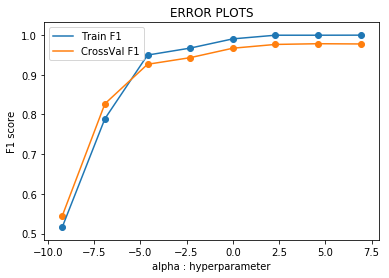

In [26]:
plt.plot(C, Train_F1_TFIDF, label='Train F1',)
plt.scatter(C, Train_F1_TFIDF)
plt.plot(C, CrossVal_F1_TFIDF, label='CrossVal F1')
plt.scatter(C, CrossVal_F1_TFIDF)
plt.legend()
plt.xlabel("alpha : hyperparameter")
plt.ylabel("F1 score")
plt.title("ERROR PLOTS")
plt.show()

In [27]:
optimal_inverse_lambda=c[CrossVal_F1_TFIDF.index(max(CrossVal_F1_TFIDF))]
print(pow(optimal_inverse_lambda,-1))

0.01


In [28]:
Classifier=LogisticRegression(C=optimal_inverse_lambda,penalty='l2',multi_class='ovr')
Classifier.fit(Train_TFIDF, Y_Train)
Y_Pred = Classifier.predict(Test_TFIDF)
final_score = f1_score(Y_Test, Y_Pred, average='micro')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [29]:
final_score

0.9723809523809523

In [0]:
z=confusion_matrix(Y_Test, Y_Pred)

In [0]:
c=["science and technology","manufacturing","art and music","history","food","travel blog"]

**Confusion Matrix**

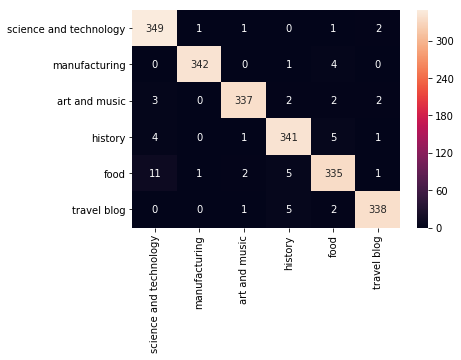

In [32]:
Train_cm = pd.DataFrame(z,index = c,columns = c)
sn.heatmap(Train_cm, annot=True,fmt="d")

In [0]:
recall = np.diag(z) / np.sum(z, axis = 1)
precision = np.diag(z) / np.sum(z, axis = 0)

In [34]:
recall

array([0.98587571, 0.98559078, 0.97398844, 0.96875   , 0.94366197,
       0.97687861])

In [35]:
precision

array([0.95095368, 0.99418605, 0.98538012, 0.96327684, 0.95988539,
       0.98255814])

In [36]:
2*(precision * recall) / (precision + recall) # F1 Score

array([0.96809986, 0.98986975, 0.97965116, 0.96600567, 0.95170455,
       0.97971014])

**Metrics Plot**

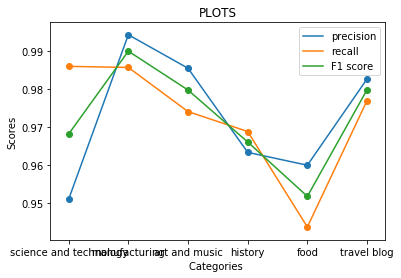

In [37]:
plt.plot(c,precision, label='precision')
plt.scatter(c,precision)
plt.plot(c,recall, label='recall')
plt.scatter(c,recall)
plt.plot(c,2*(precision * recall) / (precision + recall) , label='F1 score')
plt.scatter(c,2*(precision * recall) / (precision + recall))
plt.legend()
plt.xlabel("Categories ")
plt.ylabel("Scores")
plt.title("PLOTS")

plt.show()

**Observations :**

*   Optimal value of lambda is 0.01
*   The algorithm works very well .



# **Shallow NN ( 2 hidden layer neural net )**

**Importing libraries**

In [38]:
from keras.utils import np_utils 
from keras.initializers import RandomNormal
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


In [0]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y, test_size=0.3,stratify=Y)

In [40]:
Y_Train.value_counts()

science and technology    1242
art and music             1238
manufacturing             1231
travel blog               1212
food                      1212
history                   1212
Name: category, dtype: int64

In [0]:
Y_Train=array(Y_Train)

In [42]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_Train)
print(Y_Train)

['manufacturing' 'history' 'science and technology' ... 'food' 'food'
 'history']


In [43]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
Y_Train=onehot_encoded

In [0]:
Y_Test=array(Y_Test)

In [46]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_Test)
print(integer_encoded)

[1 0 0 ... 0 0 5]


In [47]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
Y_Test=onehot_encoded

In [0]:
tf_idf=TfidfVectorizer(ngram_range=(1,2))

In [0]:
tf_idf.fit(X_Train)
Train_TFIDF = tf_idf.transform(X_Train)
Test_TFIDF= tf_idf.transform(X_Test) 

In [0]:
X_Train = preprocessing.normalize(Train_TFIDF)
X_Test = preprocessing.normalize(Test_TFIDF)

In [0]:
output_dim = 6
input_dim = X_Train.shape[1]
batch_size = 64 
nb_epoch = 20

In [0]:
model_Relu = Sequential()

In [54]:
model_Relu.add(Dense(512, activation='relu', input_dim=input_dim , kernel_initializer=RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model_Relu.add(Dense(128, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.1, seed=None)))
model_Relu.add(Dense(output_dim, activation='softmax'))
model_Relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history= model_Relu.fit(X_Train, Y_Train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_Test, Y_Test))
model_Relu.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 7347 samples, validate on 3149 samples
Epoch 1/20
7347/7347 [==============================] - 8s 1ms/step - loss: 1.0313 - acc: 0.7200 - val_loss: 0.1766 - val_acc: 0.9559
Epoch 2/20
7347/7347 [==============================] - 6s 847us/step - loss: 0.0403 - acc: 0.9947 - val_loss: 0.0989 - val_acc: 0.9667
Epoch 3/20
7347/7347 [==============================] - 6s 847us/step - loss: 0.0055 - acc: 0.9990 - val_loss: 0.0990 - val_acc: 0.9679
Epoch 4/20
7347/7347 [==============================] - 6s 848us/step - loss: 0.0044 - acc: 0.9990 - val_loss: 0.0952 - val_acc: 0.9695
Epoch 5/20
7347/7347 [==============================] - 6s 842us/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.0960 - val_acc: 0.9673
Epoch 6/20
7347/7347 [==============================] - 6s 845us/step - loss: 0.0038 - acc: 0.9992 - val_loss: 0.0979 - val_acc: 0.9660
Epoch 7/20
7347/73

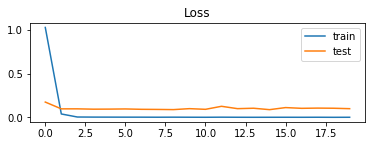

In [55]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

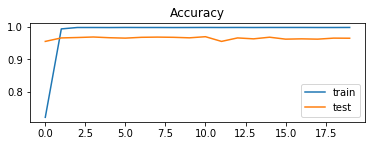

In [56]:
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [0]:
yhat_classes = model_Relu.predict_classes(X_Test, verbose=0)

In [0]:
matrix = confusion_matrix(integer_encoded, yhat_classes)

**Confusion Matrix**

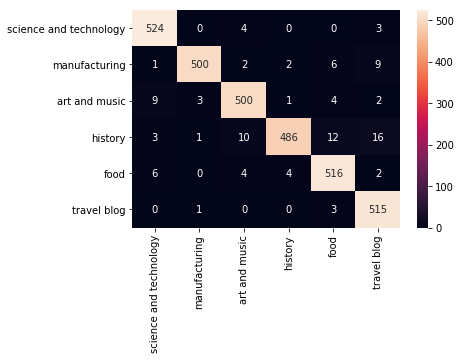

In [59]:
Train_cm = pd.DataFrame(matrix,index = c,columns = c)
sn.heatmap(Train_cm, annot=True,fmt="d")

In [0]:
recall = np.diag(matrix) / np.sum(matrix, axis = 1)
precision = np.diag(matrix) / np.sum(matrix, axis = 0)

In [61]:
2*(precision * recall) / (precision + recall) # F1 Score

array([0.97579143, 0.97560976, 0.96246391, 0.95200784, 0.96178938,
       0.96622889])

In [62]:
precision

array([0.96500921, 0.99009901, 0.96153846, 0.98580122, 0.95378928,
       0.94149909])

In [63]:
recall

array([0.98681733, 0.96153846, 0.96339114, 0.92045455, 0.96992481,
       0.99229287])

**Metrics Plot**

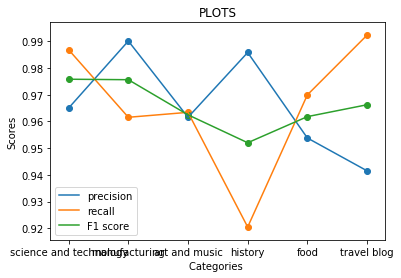

In [64]:
plt.plot(c,precision, label='precision')
plt.scatter(c,precision)
plt.plot(c,recall, label='recall')
plt.scatter(c,recall)
plt.plot(c,2*(precision * recall) / (precision + recall) , label='F1 score')
plt.scatter(c,2*(precision * recall) / (precision + recall))
plt.legend()
plt.xlabel("Categories ")
plt.ylabel("Scores")
plt.title("PLOTS")
plt.show()

**Observations :**

*   Test Accuracy : - 0.9657
*   Test Loss :- 0.1010



# **LSTM**

**Importing libraries **

In [0]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
numpy.random.seed(7)
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.preprocessing import text

In [66]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100
tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16941 unique tokens.


In [67]:
x = tokenizer.texts_to_sequences(X.values)
x = sequence.pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x.shape)

Shape of data tensor: (10496, 300)


In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(x,Y, test_size=0.3,stratify=Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(7347, 300) (7347,)
(3149, 300) (3149,)


In [0]:
Y_train=array(Y_train)

In [70]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_train)
print(Y_train)

['science and technology' 'art and music' 'manufacturing' ...
 'art and music' 'manufacturing' 'manufacturing']


In [71]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
Y_train=onehot_encoded

In [0]:
Y_test=array(Y_test)

In [74]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_test)
print(integer_encoded)

[2 0 0 ... 2 0 5]


In [75]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
Y_test=onehot_encoded

In [77]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 6612 samples, validate on 735 samples
Epoch 1/10
6612/6612 [==============================] - 59s 9ms/step - loss: 1.2917 - acc: 0.6573 - val_loss: 0.4749 - val_acc: 0.9116
Epoch 2/10
6612/6612 [==============================] - 58s 9ms/step - loss: 0.2303 - acc: 0.9534 - val_loss: 0.1874 - val_acc: 0.9497
Epoch 3/10
6612/6612 [==============================] - 59s 9ms/step - loss: 0.0572 - acc: 0.9897 - val_loss: 0.1530 - val_acc: 0.9524
Epoch 4/10
6612/6612 [==============================] - 56s 9ms/step - loss: 0.0261 - acc: 0.9952 - val_loss: 0.1235 - val_acc: 0.9673
Epoch 5/10
6612/6612 [==============================] - 57s 9ms/step - loss: 0.0149 - acc: 0.9974 - val_loss: 0.1275 - val_acc: 0.9673
Epoch 6/10
6612/6612 [==============================] - 58s 9ms/step - loss: 0.0089 - acc: 0.9995 - val_loss: 0.1400 - val_acc: 0.9605
Epoch 7/10
6612/6612 [======

In [78]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


3149/3149 [==============================] - 19s 6ms/step
Test set
  Loss: 0.125
  Accuracy: 0.965


In [0]:
yhat_classes = model.predict_classes(X_test, verbose=0)

In [0]:
matrix = confusion_matrix(integer_encoded, yhat_classes)

**Confusion Matrix**

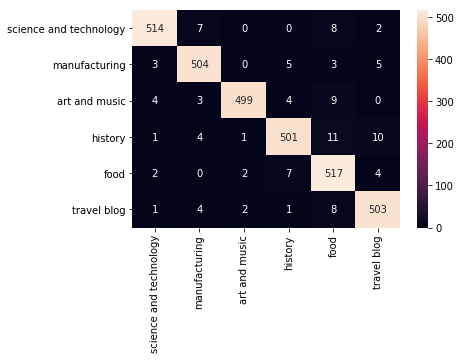

In [81]:
Train_cm = pd.DataFrame(matrix,index = c,columns = c)
sn.heatmap(Train_cm, annot=True,fmt="d")

In [0]:
recall = np.diag(matrix) / np.sum(matrix, axis = 1)
precision = np.diag(matrix) / np.sum(matrix, axis = 0)

In [83]:
recall

array([0.96798493, 0.96923077, 0.96146435, 0.94886364, 0.97180451,
       0.96917148])

In [84]:
precision

array([0.97904762, 0.96551724, 0.99007937, 0.96718147, 0.92985612,
       0.95992366])

In [85]:
2*(precision * recall) / (precision + recall) # F1 Score

array([0.97348485, 0.96737044, 0.97556207, 0.95793499, 0.95036765,
       0.96452541])

**Metrics Plot**

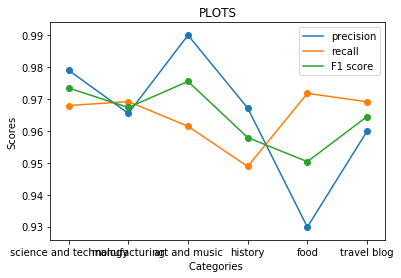

In [86]:
plt.plot(c,precision, label='precision')
plt.scatter(c,precision)
plt.plot(c,recall, label='recall')
plt.scatter(c,recall)
plt.plot(c,2*(precision * recall) / (precision + recall) , label='F1 score')
plt.scatter(c,2*(precision * recall) / (precision + recall))
plt.legend()
plt.xlabel("Categories ")
plt.ylabel("Scores")
plt.title("PLOTS")
plt.show()

**Observations :**

*   Test Accuracy : - 0.9551
*   Test Loss :- 0.1446

